In [1]:
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

{'name': 'LCLS2',
 'species': 'electron',
 'Lquad': 0.1244,
 'energy': 80000000.0,
 'Twiss0': [1e-06, 1e-06, 5.01, 5.01, 0.049, 0.049],
 'rMatx': [1, 2.2, 0, 1],
 'rMaty': [1, 2.2, 0, 1]}

In [2]:
from pyemittance.simulation import BeamSim
import numpy as np


BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])
# sim.screen_sigma('x'), sim.screen_sigma('y')
quad_vals = np.linspace(-2,2, 4)
meas =  np.array([sim.beam_size_meas(v) for v in quad_vals])
meas_x = meas[:,0]
meas_y = meas[:,1]

In [3]:
sim.beam_size_meas(0)

(0.000316975039076531, 0.0005391478973939177)

(1.0000000000000019e-06,
 2.0000000000000003e-06,
 9.999999999999984,
 10.999999999999986,
 -0.999999999999999,
 -1.9999999999999996)

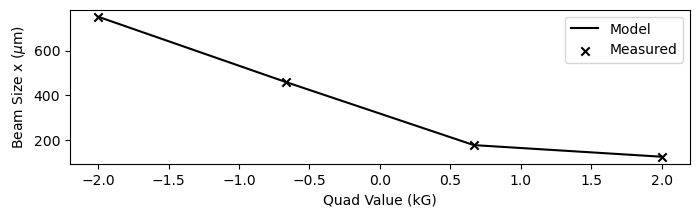

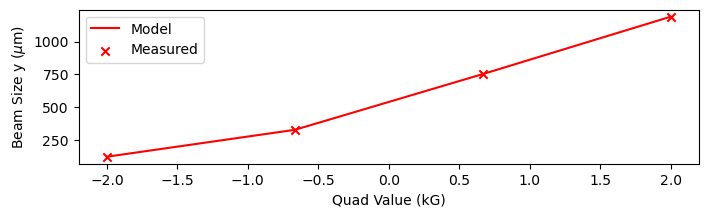

In [4]:
ef = EmitCalc({'x': quad_vals,'y': quad_vals},
              {'x': meas_x ,'y': meas_y},
              {'x': meas_x*0.03 ,'y': meas_y*0.03},
              config_dict=CONFIG,
             )

ef.plot = True         
ef.calc_bmag = True
result = ef.get_emit()

result['norm_emit_x'], result['norm_emit_y'], result['beta_x'], result['beta_y'], result['alpha_x'], result['alpha_y']

In [5]:
result['emit_x'],result['screen_bmagx'] 

(6.3876171836832415e-09, 1.2661958717461654)

In [6]:
result['emit_y'], result['screen_bmagy']

(1.2775234367366461e-08, 1.182277823247588)

In [7]:
np.sqrt(result['emit_x']*result['emit_y'])

9.033454852412266e-09

In [8]:
import torch
from emitopt.utils import get_quad_strength_conversion_factor

energy = ef.energy*1.e-9
q_len = ef.quad_len
d = ef.rmat[0][0,1]
scale = get_quad_strength_conversion_factor(E=energy, q_len=q_len)
k = torch.tensor(scale*quad_vals)
beam_size_sq_x = torch.tensor(meas_x).pow(2).reshape(1,-1)
beam_size_sq_y = torch.tensor(meas_y).pow(2).reshape(1,-1)


In [9]:
from emitopt.utils import compute_emit_bmag_thick_quad, build_quad_rmat


beta0x, alpha0x = ef.twiss0['x'][1:3]
rmat_quad_to_screen = build_quad_rmat(k=torch.tensor([0.]), q_len=d)[0]
emit, bmag, sig, is_valid = compute_emit_bmag_thick_quad(k=k, 
                                                             y_batch=beam_size_sq_x, 
                                                             q_len=q_len, 
                                                             distance=d,
                                                             beta0=beta0x, 
                                                             alpha0=alpha0x
                                                            )
print('emit_x:', emit)
print('bmag_x:', bmag)

beta0y, alpha0y = ef.twiss0['y'][1:4]
rmat_quad_to_screen = build_quad_rmat(k=torch.tensor([0.]), q_len=d)[0]
emit, bmag, sig, is_valid = compute_emit_bmag_thick_quad(k=-k, 
                                                             y_batch=beam_size_sq_y, 
                                                             q_len=q_len, 
                                                             distance=d,
                                                             beta0=beta0y, 
                                                             alpha0=alpha0y
                                                            )
print('emit_y:', emit)
print('bmag_y:', bmag)

emit_x: tensor([[6.4008e-09]], dtype=torch.float64)
bmag_x: tensor([[1.2718]], dtype=torch.float64)
emit_y: tensor([[1.2804e-08]], dtype=torch.float64)
bmag_y: tensor([[1.1834]], dtype=torch.float64)


c:\users\dylan\slac\emitopt\emitopt\utils.py:1155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
c:\users\dylan\slac\emitopt\emitopt\utils.py:1156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)
c:\users\dylan\slac\emitopt\emitopt\utils.py:969: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
c:\users\dylan\slac\emitopt\emitopt\utils.py:970: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

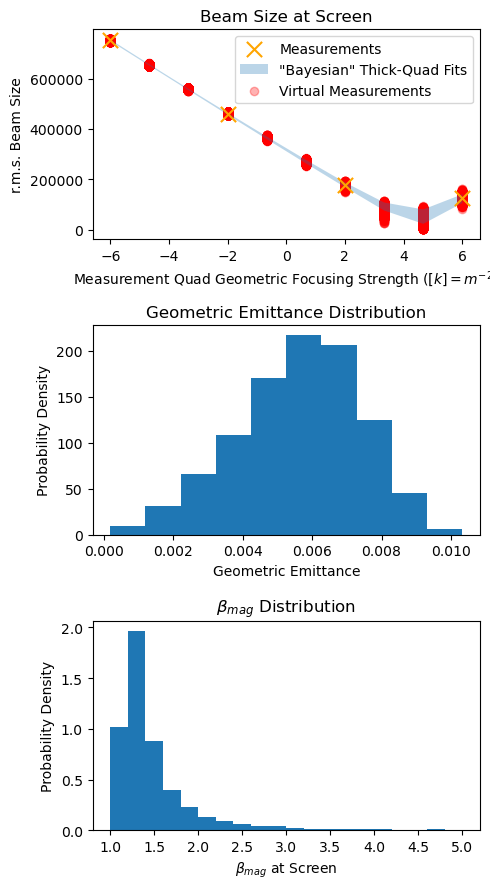

median emit_x: tensor(0.0058, dtype=torch.float64)
median bmag_x: tensor(1.3370, dtype=torch.float64)


In [10]:
from emitopt.utils import get_valid_emit_bmag_samples_from_quad_scan
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors import GammaPrior

beta0x, alpha0x = ef.twiss0['x'][1:3]

emit, bmag = get_valid_emit_bmag_samples_from_quad_scan(k=k,
#                                             y=torch.tensor(meas_x).reshape(1,-1),
                                            y=torch.tensor(meas_x).reshape(1,-1)*1.e3,
                                            q_len=q_len,
                                            distance=d,
                                            beta0=beta0x,
                                            alpha0=alpha0x,
                                            n_samples=10000,
                                            visualize=True,
                                            covar_module = ScaleKernel(PolynomialKernel(power=2)), 
                                            noise_prior=GammaPrior(1.0, 100.0)
                                            )[:2]
print('median emit_x:', emit.median())
print('median bmag_x:', bmag.median())

c:\users\dylan\slac\emitopt\emitopt\utils.py:1155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
c:\users\dylan\slac\emitopt\emitopt\utils.py:1156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)
c:\users\dylan\slac\emitopt\emitopt\utils.py:969: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
c:\users\dylan\slac\emitopt\emitopt\utils.py:970: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

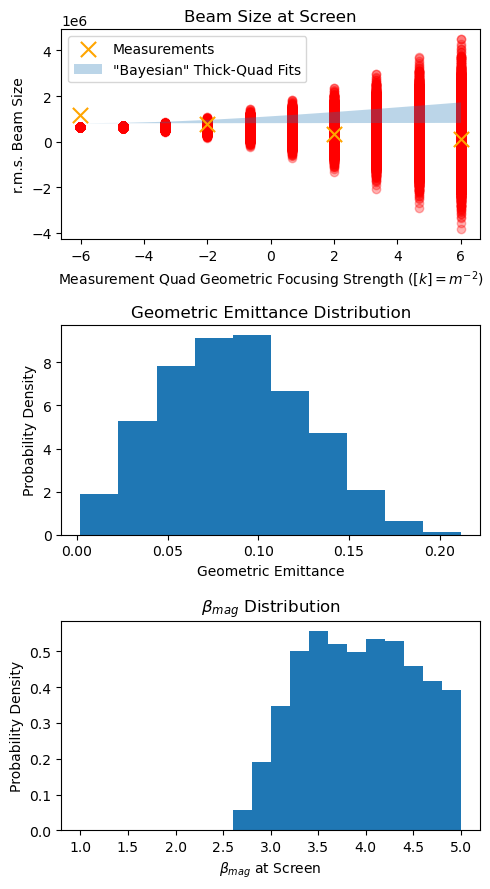

median emit_y: tensor(0.0853, dtype=torch.float64)
median bmag_y: tensor(4.9696, dtype=torch.float64)


In [11]:
beta0y, alpha0y = ef.twiss0['x'][1:3]
from gpytorch.kernels import PolynomialKernel, ScaleKernel
from gpytorch.priors import GammaPrior
emit, bmag = get_valid_emit_bmag_samples_from_quad_scan(k=-k,
                                            y=torch.tensor(meas_y).reshape(1,-1)*1.e3,
                                            q_len=q_len,
                                            distance=d,
                                            beta0=beta0y,
                                            alpha0=alpha0y,
                                            n_samples=10000,
                                            visualize=True,
                                            covar_module = ScaleKernel(PolynomialKernel(power=2), 
                                                                       outputscale_prior=GammaPrior(2.0, 0.15)),
                                           )[:2]
print('median emit_y:', emit.median())
print('median bmag_y:', bmag.median())

c:\users\dylan\slac\emitopt\emitopt\utils.py:1053: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
c:\users\dylan\slac\emitopt\emitopt\utils.py:1054: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)
c:\users\dylan\slac\emitopt\emitopt\utils.py:967: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
c:\users\dylan\slac\emitopt\emitopt\utils.py:968: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

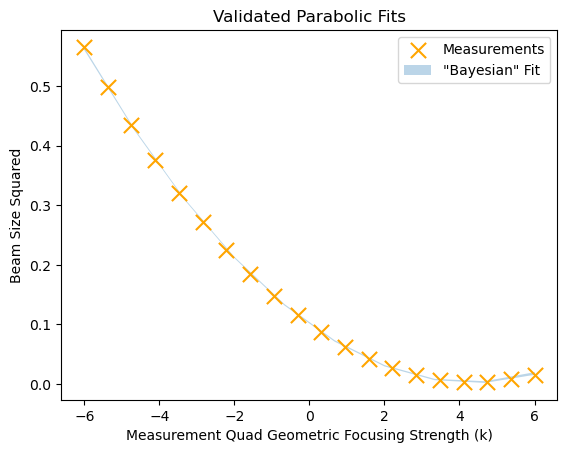

tensor(6.1652e-09, dtype=torch.float64)

In [12]:
from emitopt.utils import get_valid_emit_samples_from_quad_scan
emit = get_valid_emit_samples_from_quad_scan(
    k=k,
    y=torch.tensor(meas_x).reshape(1,-1)*1.e3,
    q_len=q_len,
    distance=d,
    visualize=True,
    covar_module = ScaleKernel(PolynomialKernel(power=2), 
                               outputscale_prior=GammaPrior(2.0, 0.15)),
)[0]
emit.mean()*1.e-6

c:\users\dylan\slac\emitopt\emitopt\utils.py:998: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
c:\users\dylan\slac\emitopt\emitopt\utils.py:999: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)
c:\users\dylan\slac\emitopt\emitopt\utils.py:912: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
c:\users\dylan\slac\emitopt\emitopt\utils.py:913: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

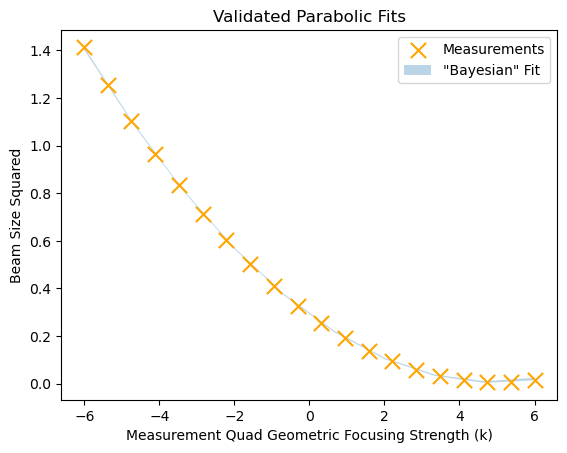

tensor(1.3881e-08, dtype=torch.float64)

In [11]:
emit = get_valid_emit_samples_from_quad_scan(
    k=-k,
    y=torch.tensor(meas_y).reshape(1,-1)*1.e3,
    q_len=q_len,
    distance=d,
    visualize=True,
    covar_module = ScaleKernel(PolynomialKernel(power=2), 
                               outputscale_prior=GammaPrior(2.0, 0.15)),
)[0]
emit.mean()*1.e-6